# 無使用遷移學習Transfer Learning Sentiment analysis

# 30-Keras-純CNN&LSTM(編號1&2-train80%)

若 model.layers[0].trainable = False 似乎無法學習!! 只有五成正確率

若 model.layers[0].trainable = True  有85%正確率

CNN兩類準確率達 有85%正確率

In [1]:
import copy
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import sys
import os
import re

# from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling1D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback
from keras.optimizers import *

Using TensorFlow backend.


# Hotel data格式前處理

透過clean_dataset整理資料

label必須編碼為0,1,2,3,..

In [2]:
import pandas as pd

In [3]:
data=pd.read_csv('./data/hotel_data.csv',encoding='utf8')
data = data[['text','polarity']]

In [4]:
data.head(10)

,text,polarity
0,My daughter and I just returned from a four ni...,NEGATIVE
1,I had searched for a good hotel at a rate of u...,OBJECTIVE
2,Big mistake.,NEGATIVE
3,"Our room was tiny,",NEGATIVE
4,and the bath was small too.,NEGATIVE
5,The public areas were somewhat dingy and showe...,NEGATIVE
6,Even the bath towels were worn and becoming st...,NEGATIVE
7,"Speaking of such, the maid did not replace sha...",NEGATIVE
8,You had to put a sign on the bed if you wanted...,NEGATIVE
9,The minibar was one of the kind that you have ...,NEGATIVE


In [5]:
print(data[ data['polarity'] == 'POSITIVE'].size)
print(data[ data['polarity'] == 'NEGATIVE'].size)
print(data[ data['polarity'] == 'OBJECTIVE'].size)

23046
25020
15200


In [6]:
data = data[ (data['polarity'] == 'POSITIVE') |(data['polarity'] == 'NEGATIVE')]

In [7]:
print(data[ data['polarity'] == 'POSITIVE'].size)
print(data[ data['polarity'] == 'NEGATIVE'].size)
print(data[ data['polarity'] == 'OBJECTIVE'].size)

23046
25020
0


In [8]:
data['polarity'] = data['polarity'].replace({'POSITIVE': 1, 'NEGATIVE': 0})

In [9]:
data = data.rename(columns={'polarity':'label'})

In [10]:
data.head(3)

,text,label
0,My daughter and I just returned from a four ni...,0
2,Big mistake.,0
3,"Our room was tiny,",0


In [11]:
## 切資料

from sklearn.model_selection import train_test_split

X_train_, X_test_, Y_train, Y_test = \
    train_test_split( data['text'], data['label'], test_size=0.2, random_state=42, stratify = data['label'])

/opt/conda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [12]:
input_text = data['text']

In [13]:
input_text[0:2]

0    My daughter and I just returned from a four ni...
2                                         Big mistake.
Name: text, dtype: object

In [14]:
input_text.shape

(24033,)

In [15]:
# 20000
num_words = 20000
tok = Tokenizer(num_words)
tok.fit_on_texts(input_text)

In [16]:
len(tok.word_index)

13117

In [17]:
X_train = tok.texts_to_sequences(X_train_)
X_test  = tok.texts_to_sequences(X_test_)

X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test  = sequence.pad_sequences(X_test,  maxlen=200)

In [18]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [19]:
len(X_train)

19226

In [20]:
Y_train[0:10]

13386    0
4378     0
13797    0
30728    0
2241     0
22352    0
20933    1
9681     1
3271     0
9394     0
Name: label, dtype: int64

In [21]:
len(Y_train)

19226

In [22]:
Y_train

13386    0
4378     0
13797    0
30728    0
2241     0
22352    0
20933    1
9681     1
3271     0
9394     0
30363    0
15171    1
3100     1
18783    0
7051     0
24130    1
9191     1
23097    1
6163     1
26460    0
4806     1
3543     0
21434    0
30676    1
4950     0
1867     1
2680     0
29934    1
890      0
25126    0
        ..
8544     1
18541    0
23587    0
18117    0
1980     1
6066     1
12472    0
12977    1
2318     0
30700    0
30457    1
22531    1
12259    1
14389    1
15827    1
6788     0
30485    1
30685    1
30144    0
13691    0
10073    0
17092    1
26733    1
14713    1
11409    1
26612    0
29536    1
13338    1
24279    1
9204     0
Name: label, dtype: int64

# 自己繪圖展示train, validation, test準確率

In [23]:
%matplotlib inline
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_epoch_end(self,epoch, logs={}):
        x, y = X_test, Y_test
        lss, acc = self.model.evaluate(x, y, verbose=0)
        #self.losses.append([logs.get('loss'),logs.get('acc'),logs.get('val_loss'),logs.get('val_acc'),lss, acc])
        self.losses.append({'train_loss':logs.get('loss'),'train_metrics':logs.get('acc'),
                            'val_loss':logs.get('val_loss'),'val_metrics':logs.get('val_acc'),
                            'test_loss':lss,'test_metrics':acc,
                           })
        #trlss = logs.get('loss')
        #tracc = logs.get('acc')
        #valss = logs.get('val_loss')
        #vaacc = logs.get('val_acc')
        #print('\nepochs:{}'.format(epoch))
        #print('\nTrain loss: {}, acc: {}'.format(trlss, tracc))
        #print('\nValidation loss: {}, acc: {}'.format(valss, vaacc)) 
        #print('\nTesting loss: {}, acc: {}'.format(lss, acc))

# LSTM

In [37]:
model = Sequential()

model.add(Embedding(num_words, 10, input_length= 200))
model.add(Dropout(0.5))

model.add(LSTM(16,activation='relu'))

model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Activation('relu'))

#model.add(GlobalAveragePooling1D())
#model.add(Dense(1, activation='softmax'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

#詞嵌入 採用預訓練的 向量

#model.layers[0].set_weights([weights])
#model.layers[0].trainable = True

#optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 10)           200000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 10)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2176      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
__________

In [25]:
%%time
history = LossHistory()
hist=model.fit(X_train, Y_train, batch_size= 32, epochs=10, validation_split=0.1, callbacks=[history])

Train on 17303 samples, validate on 1923 samples
Epoch 1/10
17303/17303 [==============================] - 99s 6ms/step - loss: 3.2052 - acc: 0.5770 - val_loss: 7.9256 - val_acc: 0.5029
Epoch 2/10
17303/17303 [==============================] - 85s 5ms/step - loss: 8.3402 - acc: 0.4769 - val_loss: 7.9256 - val_acc: 0.5029
Epoch 3/10
17303/17303 [==============================] - 66s 4ms/step - loss: 8.3402 - acc: 0.4769 - val_loss: 7.9256 - val_acc: 0.5029
Epoch 4/10
17303/17303 [==============================] - 67s 4ms/step - loss: 8.3402 - acc: 0.4769 - val_loss: 7.9256 - val_acc: 0.5029
Epoch 5/10
17303/17303 [==============================] - 69s 4ms/step - loss: 8.3402 - acc: 0.4769 - val_loss: 7.9256 - val_acc: 0.5029
Epoch 6/10
17303/17303 [==============================] - 69s 4ms/step - loss: 8.3402 - acc: 0.4769 - val_loss: 7.9256 - val_acc: 0.5029
Epoch 7/10
17303/17303 [==============================] - 98s 6ms/step - loss: 8.3402 - acc: 0.4769 - val_loss: 7.9256 - val_acc:

In [26]:
hist_info = pd.DataFrame(history.losses)

In [27]:
hist_info

,test_loss,test_metrics,train_loss,train_metrics,val_loss,val_metrics
0,8.297867,0.479509,3.205165,0.577010,7.925596,0.50286
1,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286
2,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286
3,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286
4,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286
5,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286
6,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286
7,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286
8,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286
9,8.297867,0.479509,8.340200,0.476854,7.925596,0.50286


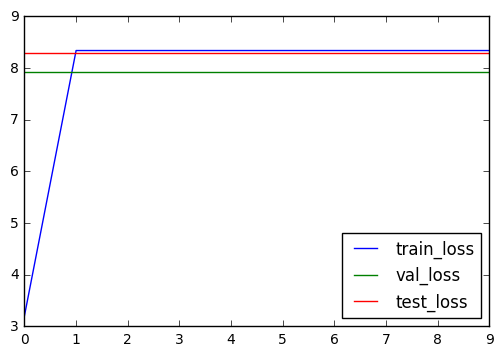

In [28]:
hist_info[['train_loss','val_loss', 'test_loss']].plot()

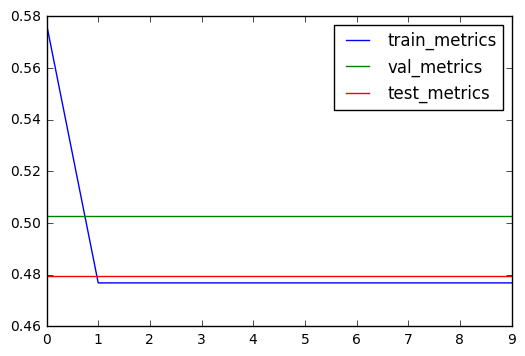

In [29]:
hist_info[['train_metrics', 'val_metrics','test_metrics',]].plot()

# CNN

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, Activation
from keras import metrics
#from keras.preprocessing import sequence

In [31]:
#nb_classes = 2

model = Sequential()
model.add(Embedding(num_words, 10, input_length= 200))
model.add(Convolution1D(activation="relu", filters=250, kernel_size=3, strides=1, padding="valid"))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
model.add(Dense(250)) 
model.add(Dropout(0.2)) 
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

#詞嵌入 採用預訓練的 向量
#model.layers[0].set_weights([weights])
#model.layers[0].trainable = False

#optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 10)           200000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 250)          7750      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 250)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24750)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               6187750   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 250)               0         
__________

In [32]:
%%time
history = LossHistory()
hist=model.fit(X_train, Y_train, batch_size= 32, epochs=10, validation_split=0.1, callbacks=[history])

Train on 17303 samples, validate on 1923 samples
Epoch 1/10
17303/17303 [==============================] - 76s 4ms/step - loss: 0.4609 - acc: 0.7743 - val_loss: 0.3695 - val_acc: 0.8544
Epoch 2/10
17303/17303 [==============================] - 86s 5ms/step - loss: 0.2714 - acc: 0.8930 - val_loss: 0.3595 - val_acc: 0.8471
Epoch 3/10
17303/17303 [==============================] - 112s 6ms/step - loss: 0.1910 - acc: 0.9290 - val_loss: 0.3912 - val_acc: 0.8466
Epoch 4/10
17303/17303 [==============================] - 86s 5ms/step - loss: 0.1316 - acc: 0.9523 - val_loss: 0.4641 - val_acc: 0.8393
Epoch 5/10
17303/17303 [==============================] - 76s 4ms/step - loss: 0.0863 - acc: 0.9684 - val_loss: 0.5985 - val_acc: 0.8346
Epoch 6/10
17303/17303 [==============================] - 76s 4ms/step - loss: 0.0601 - acc: 0.9780 - val_loss: 0.6445 - val_acc: 0.8326
Epoch 7/10
17303/17303 [==============================] - 77s 4ms/step - loss: 0.0376 - acc: 0.9864 - val_loss: 0.8633 - val_acc

In [33]:
hist_info = pd.DataFrame(history.losses)

In [34]:
hist_info

,test_loss,test_metrics,train_loss,train_metrics,val_loss,val_metrics
0,0.351094,0.849802,0.460913,0.774259,0.369506,0.854394
1,0.343459,0.854795,0.271407,0.893024,0.359544,0.847114
2,0.377277,0.850426,0.191008,0.929030,0.391171,0.846594
3,0.430313,0.847930,0.131608,0.952320,0.464098,0.839314
4,0.559562,0.840233,0.086265,0.968445,0.598454,0.834633
5,0.622333,0.829207,0.060063,0.978038,0.644504,0.832553
6,0.803024,0.835448,0.037560,0.986361,0.863332,0.825793
7,0.943157,0.822758,0.024643,0.991389,1.019147,0.818513
8,1.076673,0.837529,0.022343,0.991215,1.167890,0.828913
9,0.962510,0.828167,0.021360,0.991851,1.030490,0.826313


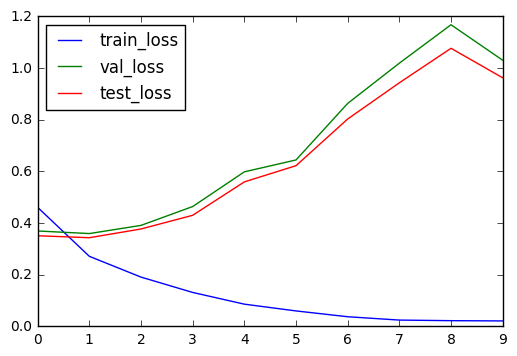

In [35]:
hist_info[['train_loss','val_loss', 'test_loss']].plot()

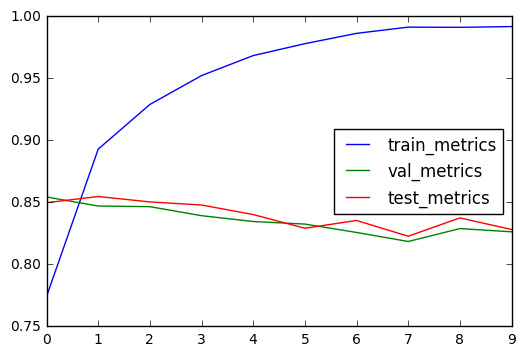

In [36]:
hist_info[['train_metrics', 'val_metrics','test_metrics',]].plot()